In [52]:
import psycopg2 as pg
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
user = input("Username: ")
password = getpass.getpass("Password: ")
conn = pg.connect(dbname='csci403', user=user, password=password, host='codd.mines.edu', port='5433')
del user
del password
cur = conn.cursor()

In [54]:
query = """SELECT tsla.day, tsla.price, btc.price FROM tsla, btc WHERE tsla.day = btc.day;"""
cur.execute(query)
sql_table = cur.fetchall()
df = pd.DataFrame(sql_table, columns=['day', 'tsla_price', 'btc_price'])
df

,day,tsla_price,btc_price
0,2010-06-29,19.00,0.0
1,2010-06-30,25.79,0.0
2,2010-07-01,25.00,0.0
3,2010-07-02,23.00,0.0
4,2010-07-06,20.00,0.0
...,...,...,...
1907,2018-01-25,348.27,11214.4
1908,2018-01-26,341.50,10969.8
1909,2018-01-29,339.85,11212.7
1910,2018-01-30,345.14,10184.1


In [55]:
np.corrcoef(df['tsla_price'], df['btc_price'])

array([[1.       , 0.4936166],
       [0.4936166, 1.       ]])

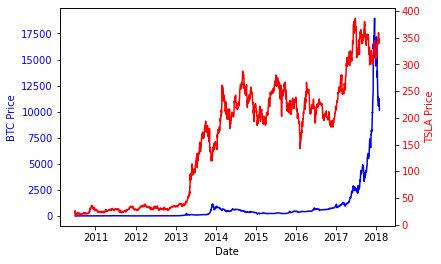

In [56]:
fig, ax1 = plt.subplots()
ax1.plot(df['day'], df['btc_price'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(df['day'], df['tsla_price'], color='red')
ax2.set_ylabel('TSLA Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

In [57]:
query = """SELECT * FROM btc;"""
cur.execute(query)
sql_table = cur.fetchall()
df_btc = pd.DataFrame(sql_table, columns=['day', 'price', 'total_btc', 'hash_rate', 'difficulty', 'output_volume'])
df_btc

,day,price,total_btc,hash_rate,difficulty,output_volume
0,2010-02-17,0.0,2043200.0,2.920000e-05,2.527740e+00,65173.10
1,2010-02-18,0.0,2054650.0,2.880000e-05,2.527740e+00,18911.70
2,2010-02-19,0.0,2063600.0,2.250000e-05,2.527740e+00,9749.98
3,2010-02-20,0.0,2074700.0,2.790000e-05,2.527740e+00,11150.00
4,2010-02-21,0.0,2085400.0,2.690000e-05,2.527740e+00,12266.80
...,...,...,...,...,...,...
2901,2018-01-27,11524.8,16830300.0,2.031570e+07,2.600000e+12,1363300.00
2902,2018-01-28,11765.7,16832300.0,2.044510e+07,2.600000e+12,3128910.00
2903,2018-01-29,11212.7,16834100.0,1.915120e+07,2.600000e+12,1941050.00
2904,2018-01-30,10184.1,16836200.0,2.160970e+07,2.600000e+12,2359670.00


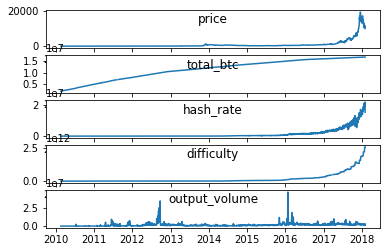

In [58]:
fig, ax = plt.subplots(5)
for i, name in enumerate(df_btc.columns[1:]):
    ax[i].plot(df_btc['day'], df_btc[name])
    ax[i].set_title(name, y=0.5)

In [59]:
query = """SELECT * FROM pollution;"""
cur.execute(query)
sql_table_pollution = cur.fetchall()
df_pollution = pd.DataFrame(sql_table_pollution, columns=['country_name', 'country_code', '2010', '2011', '2012', '2013','2014','2015','2016','2017'])
df_pollution

,country_name,country_code,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,65.245592,66.835727,66.023174,61.366745,59.010330,61.252656,56.287047,56.910808
1,Angola,AGO,33.787247,33.104195,33.415495,34.663923,32.974025,32.729873,31.785389,32.388505
2,Albania,ALB,21.277828,22.772537,20.578259,19.938517,18.883955,19.512540,18.189934,18.200603
3,Andorra,AND,12.807197,13.273506,12.407053,11.813673,10.830418,11.462178,10.255834,10.307621
4,Arab World,ARB,53.787001,52.652279,53.297270,54.053822,52.583603,60.406813,58.764905,58.689259
...,...,...,...,...,...,...,...,...,...,...
235,Samoa,WSM,14.288094,14.693096,13.627882,13.382522,12.643560,12.321796,11.366298,11.548027
236,"Yemen, Rep.",YEM,45.979470,50.835291,51.434454,52.998443,48.338653,54.260287,50.127626,50.456007
237,South Africa,ZAF,27.138587,26.557873,26.577087,26.729262,26.722212,26.112972,25.140416,25.102205
238,Zambia,ZMB,28.836379,28.987117,29.742040,29.112221,28.493252,28.375452,27.355674,27.438035


In [60]:
query = """SELECT EXTRACT(YEAR FROM day), AVG(price) FROM btc GROUP BY EXTRACT(YEAR FROM day) ORDER BY EXTRACT(YEAR FROM day);"""
cur.execute(query)

btc_avg_price = cur.fetchall()
df_btc_avg_price = pd.DataFrame(btc_avg_price, columns=['year','avg'])

df_btc_avg_price

,year,avg
0,2010.0,0.072337
1,2011.0,6.050227
2,2012.0,8.465060
3,2013.0,189.546581
4,2014.0,526.021945
5,2015.0,272.361069
6,2016.0,567.278348
7,2017.0,4001.162575
8,2018.0,13047.251229


[[1.         0.29696076]
 [0.29696076 1.        ]]


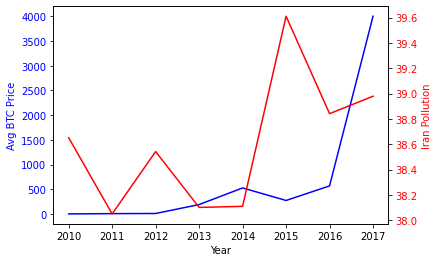

In [61]:
iran = df_pollution[df_pollution['country_code']=='IRN']
iran = iran.drop(columns=['country_name', 'country_code'])
iran = np.reshape(iran.to_numpy(), -1)
btc_avg = df_btc_avg_price['avg'][:-1]

fig, ax1 = plt.subplots()
ax1.plot(range(2010,2018), btc_avg, color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg BTC Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(2010,2018), iran, color='red')
ax2.set_ylabel('Iran Pollution', color='red')
ax2.tick_params(axis='y', labelcolor='red')

print(np.corrcoef(btc_avg, iran))